### Imports

In [352]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression,LogisticRegression

from sklearn.tree          import DecisionTreeRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import ExtraTreesRegressor
from sklearn.ensemble      import AdaBoostRegressor
from sklearn.ensemble      import GradientBoostingRegressor
from xgboost               import XGBRegressor
from lightgbm              import LGBMRegressor
from catboost              import CatBoostRegressor

from sklearn               import metrics

import time

In [353]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 10})

In [354]:
# Aquifers
# Aquifers
Auser_path = './datasets/Aquifer_Auser.csv'
Doganella_path = './datasets/Aquifer_Doganella.csv'
Luco_path = './datasets/Aquifer_Luco.csv'
Petrignano_path = './datasets/Aquifer_Petrignano.csv'

# Lake
Bilancino_path = './datasets/Lake_Bilancino.csv'

# River
Arno_path = './datasets/River_Arno.csv'

# Water springs
Amiata_path = './datasets/Water_Spring_Amiata.csv'
Lupa_path = './datasets/Water_Spring_Lupa.csv'
Madonna_path = './datasets/Water_Spring_Madonna_di_Canneto.csv'

In [355]:
Auser_path

'./datasets/Aquifer_Auser.csv'

In [356]:
# Column names for target variables
targets = {
    'Auser': [
        'Depth_to_Groundwater_SAL',
        'Depth_to_Groundwater_CoS',
        'Depth_to_Groundwater_LT2'
        ],
    'Doganella': [
        'Depth_to_Groundwater_Pozzo_1',
        'Depth_to_Groundwater_Pozzo_2',
        'Depth_to_Groundwater_Pozzo_3',
        'Depth_to_Groundwater_Pozzo_4',
        'Depth_to_Groundwater_Pozzo_5',
        'Depth_to_Groundwater_Pozzo_6',
        'Depth_to_Groundwater_Pozzo_7',
        'Depth_to_Groundwater_Pozzo_8',
        'Depth_to_Groundwater_Pozzo_9'
        ],
    'Luco': [
        'Depth_to_Groundwater_Podere_Casetta'
        ],
    'Petrignano': [
        'Depth_to_Groundwater_P24',
        'Depth_to_Groundwater_P25'
        ],
    'Bilancino': [
        'Lake_Level', 
        'Flow_Rate'
        ],
    'Arno': [
        'Hydrometry_Nave_di_Rosano'
        ],
    'Amiata': [
        'Flow_Rate_Bugnano',
        'Flow_Rate_Arbure',
        'Flow_Rate_Ermicciolo',
        'Flow_Rate_Galleria_Alta'
        ],
    'Lupa': [
        'Flow_Rate_Lupa'
        ],
    'Madonna': [
        'Flow_Rate_Madonna_di_Canneto'
        ]
    }

In [357]:
# Models to be compared
models = {
  "Regression":    LinearRegression(),
  "Decision Tree": DecisionTreeRegressor(),
  "Extra Trees":   ExtraTreesRegressor(n_estimators=100),
  "Random Forest": RandomForestRegressor(n_estimators=100),
  "AdaBoost":      AdaBoostRegressor(n_estimators=100),
  "Skl GBM":       GradientBoostingRegressor(n_estimators=100),
  "XGBoost":       XGBRegressor(n_estimators=100),
  "LightGBM":      LGBMRegressor(n_estimators=100),
  "CatBoost":      CatBoostRegressor(n_estimators=100)
}

In [358]:
# Splits and shuffle for cross-validation
kf = KFold(3, shuffle=True, random_state=1)

In [359]:
# For applying various data frequencies
resampling = {'monthly': 'M', 'weekly': 'W', 'daily': 'D'}

In [360]:
def plot_nans(df: pd.DataFrame, obj_id: str):
    """Function calculates percentage of missing values by column
    and creates a bar plot."""
    rows, _ = df.shape
    missing_values = df.isna().sum() / rows * 100
    missing_values = missing_values[missing_values != 0]
    missing_values.sort_values(inplace=True)
    title = obj_id + ' missing values'
    plt.barh(missing_values.index, missing_values.values)
    plt.xlabel('Percentage (%)')
    plt.title(title)
    plt.show()

In [361]:
def plot_distribution(df: pd.DataFrame):
    """Function plots a histogram for parameter distribution."""
    df.hist(bins=20, figsize=(14, 10))
    plt.show()

In [362]:
def plot_correlation(df: pd.DataFrame, obj_id: str, targets: list):
    """Function calculates correlation between parameters
    and creates a heatmap."""
    title = obj_id + ' Heatmap'
    targets_correlation = df.corr()[targets]
    ax = sns.heatmap(targets_correlation, center=0, annot=True, cmap='RdBu_r')
    l, r = ax.get_ylim()
    ax.set_ylim(l + 0.5, r - 0.5)
    plt.yticks(rotation=0)
    plt.title(title)
    plt.show()

In [363]:
def plot_timeseries(df: pd.DataFrame, obj_id: str, targets: list):
    """Function plots target variable against the timescale."""
    for target in targets:
        plt.plot(df.index, df[target], label=target)
    title = obj_id + ' actual data'
    plt.legend()
    plt.title(title)
    plt.show()

In [364]:
def plot_seasonality(df: pd.DataFrame, targets: list):
    """Function creates a seasonal decomposition plot for target variables.
    Temporary interpolation of missing values is performed on a resampled
    monthly data, which does not affect the original dataset."""
    for target in targets:
        monthly_interpolated = df[target].resample('M').mean().interpolate(method='akima').dropna()
        
        decomposition = seasonal_decompose(monthly_interpolated)
        observed = decomposition.observed
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        dates = monthly_interpolated.index

        plt.plot(dates, observed, label='Original data')
        plt.plot(dates, trend, label='Trend')
        plt.plot(dates, seasonal, label='Seasonal')
        plt.plot(dates, residual, label='Residual')
        plt.legend()
        plt.title(f'{target} seasonal decomposition')
        plt.tight_layout()
        plt.show()

In [365]:
def data_cleaning(df: pd.DataFrame):
    """Function replaces 0 values with np.nan in all columns except rainfall."""
    for column in df.columns:
        if column.find('Rainfall') == -1:
            df[column] = df[column].apply(lambda x: np.nan if x == 0 else x)
    return df

In [366]:
def get_data(path: str):
    """Function extracts data from a csv file and converts date column
    to datetime index."""
    df = pd.read_csv(path,
                       parse_dates=['Date'],
                       date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%Y'))
    df.dropna(subset=['Date'], inplace=True)  # Madonna_di_Canneto dataset has empty rows
    df.set_index('Date', inplace=True)
    # Remove erroneous 0 values from all columns except rainfall
    df = data_cleaning(df)
    return df

In [367]:
def resample_data(df: pd.DataFrame, freq: str):
    """Function converts daily data into weekly or monthly averages."""
    return df.resample(freq).mean()

In [368]:
def add_seasonality(df: pd.DataFrame):
    """Function adds columns specifying year, month and day of a year
    and binary column for rainy season (October through April)."""
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Week'] = df.index.weekofyear
    df['Day'] = df.index.dayofyear
    df['Rainy_Season'] = df['Month'].apply(lambda x: 0 if 5 <= x <= 9 else 1)
    return df

In [369]:
def add_weekly_averages(df: pd.DataFrame):
    """Function adds weekly rolling average values for rainfall and temperature,
    which are used as additional features in daily datasets."""
    for column in df.columns:
        if column.find('Rainfall') > -1 or column.find('Temperature') > -1:
            df[f'{column}_weekly'] = df[column].rolling(7).mean()
    return df

In [370]:
def select_features(df: pd.DataFrame):
    """Function creates a list of most correlated features for the target."""
    target_correlation = df.corr()['Target']
    mosts_correlated = target_correlation[(target_correlation >= 0.2) | (target_correlation <= -0.2)].index.tolist()
    return mosts_correlated

In [371]:
def get_X_y(df: pd.DataFrame, target: str, steps_ahead: int):
    """Function splits data into input features and target variable,
    returns a tuple containing list of features, X and y."""
    X = df.copy()
    # Add a column that contains target value for the predicted future period
    # (shift target column backwards for required number of periods)
    X['Target'] = X[target].shift(-steps_ahead)
    # Reduce input to the most correlated features
    features = select_features(X)
    X = X[features]
    # Here the last row of actual inputs is lost
    # because there is no future period target value for it
    X.dropna(inplace=True)
    y = X.pop('Target')
    return features[:-1], X, y

In [372]:
def evaluate_models(input_data: pd.DataFrame, target: pd.Series, target_name: str):
    """Function estimates cross-val score for several models.
    If the highest cv score is above 0.6, returns a tuple
    with fitted model and its name, otherwise returns a tuple
    with None and an empty string."""

    best_cv = -1
    best_model = None
    best_model_name = ''

    for name, model in models.items():
        cv_r2 = cross_val_score(model, input_data, target, cv=kf, scoring='r2').mean()
        cv_mae = - cross_val_score(model, input_data, target, cv=kf, scoring='neg_mean_absolute_error').mean()
        cv_rmse = - cross_val_score(model, input_data, target, cv=kf, scoring='neg_mean_squared_error').mean()
        print(f'{name} cross-val score for {target_name}:\n\tR2 = {cv_r2}\n\tMAE = {cv_mae}\n\tRMSE = {cv_rmse}')

        if cv_r2 > best_cv:
            best_cv = cv_r2
            best_model = model
            best_model_name = name

    if best_cv >= 0.6:
        best_model.fit(input_data, target)
        return best_model_name, best_model
    else:
        return '', None

In [373]:
def simple_prediction(ts: pd.Series, n_periods_1: int, n_perionds_2: int, steps_ahead: int):
    """Function returns a prediction based on the actual value of the target variable
    for the latest period and two linear trend predictions equally weighted."""
    # Actual last value in the time series
    last_period_value = ts.iloc[len(ts) - 1]
    # Linear trend based on n_periods_1
    X_1 = np.array([i for i in range(1, n_periods_1 + 1)]).reshape(-1, 1)
    linear_prediction_1 = LinearRegression().fit(X_1, ts.tail(n_periods_1)).predict([[n_periods_1 + steps_ahead]])[0]
    # Linear trend based on n_periods_2
    X_2 = np.array([i for i in range(1, n_perionds_2 + 1)]).reshape(-1, 1)
    linear_prediction_2 = LinearRegression().fit(X_2, ts.tail(n_perionds_2)).predict([[n_perionds_2 + steps_ahead]])[0]
    # Average of the three values
    prediction = (last_period_value + linear_prediction_1 + linear_prediction_2) / 3
    return prediction

In [374]:
def modelling(df: pd.DataFrame, targets: list, obj_id: str, freq: str, steps_ahead: int):
    """Function preprocesses data, creates models and estimates their accuracy,
    gets prediction for the future period from the best model if R2 >= 0.6
    or uses simple prediction based on the last actual value and linear trends."""
    print(f'\nCreating {freq} model for {obj_id}\n')
    df = resample_data(df, resampling[freq])  # Change data frequency
    if freq == 'daily':
        df = add_weekly_averages(df)  # Add weekly rolling averages as a feature

    # Select input for each target that contains the most correlated features
    for target in targets:
        features, X, y = get_X_y(df, target, steps_ahead)
        model_name, model = evaluate_models(X, y, target)

        if model_name:  # Best R2 >= 0.6
            # Get the actual last row of input data from the dataset
            # (if there are NaNs, get the last row with all required features)
            input_data = df[features].dropna()
            input_date = input_data.index.max()
            input_data = input_data.iloc[len(input_data) - 1, :].values.reshape(1, -1)
            prediction = model.predict(input_data)[0]
        else:  # Low R2
            model_name = 'Average and linear trend'
            features = [target]
            input_data = df[target].dropna()
            input_date = input_data.index.max()
            # Take into account last value and trends of the last 5 and 10 periods
            prediction = simple_prediction(input_data, 5, 10, steps_ahead)

        print(f'\n{model_name} {freq} prediction for {target}: {prediction}')
        print(f'\nInput features: {", ".join(features)}\nInput date: {input_date}')
        print(f'Prediction for {steps_ahead} step(s) ahead.\n')

### Aquifer Auser

In [375]:
data = get_data(Auser_path)

In [376]:
target_cols = targets['Auser']

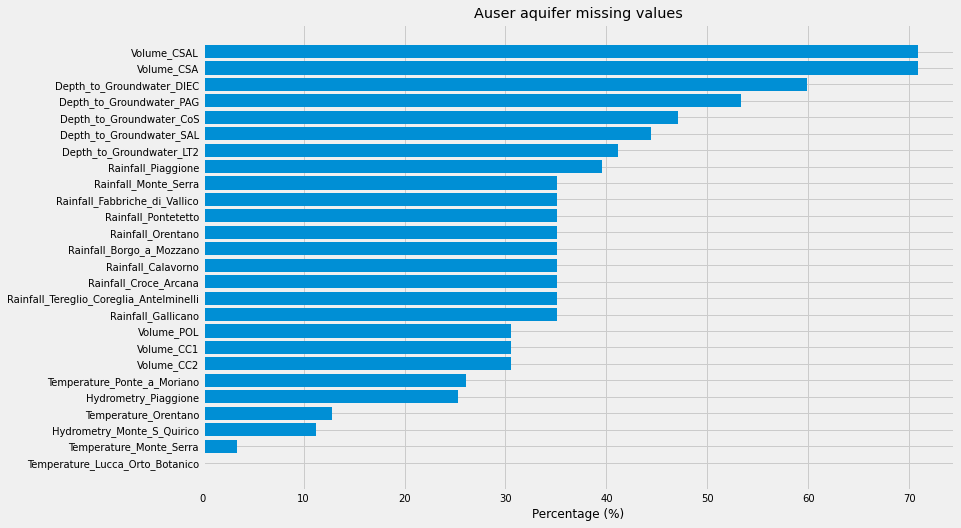

In [377]:
plot_nans(data, 'Auser aquifer')

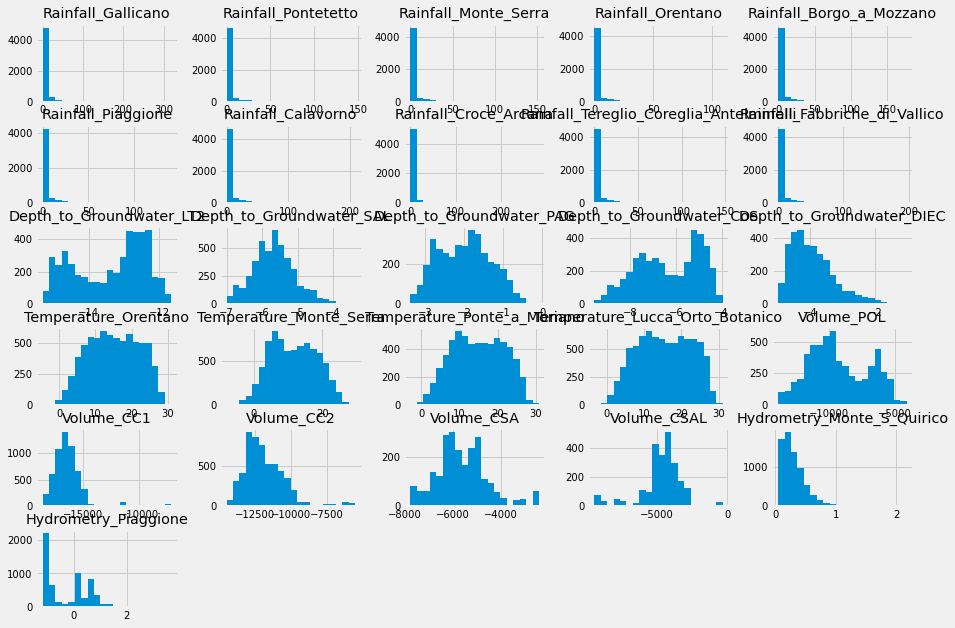

In [378]:
plot_distribution(data)

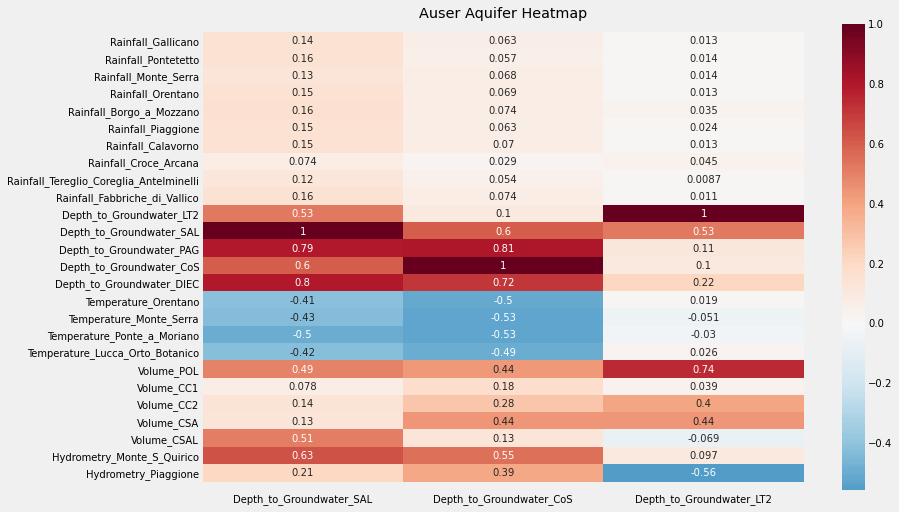

In [379]:
plot_correlation(data, 'Auser Aquifer', target_cols)

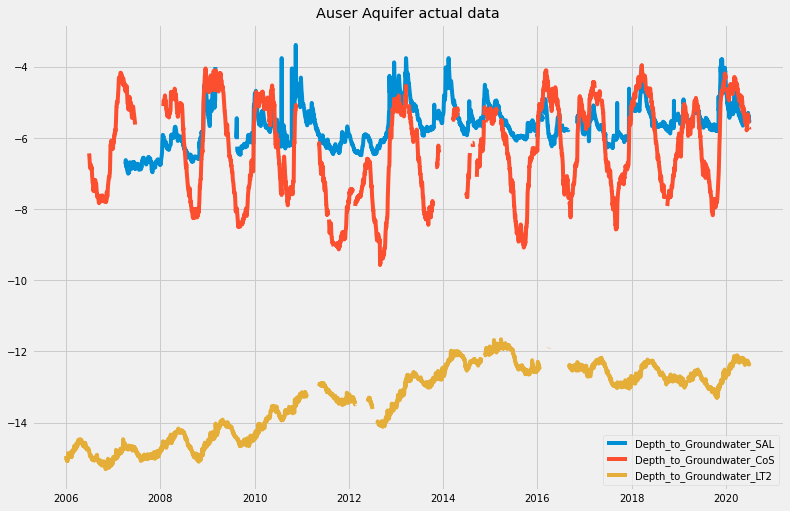

In [380]:
plot_timeseries(data, 'Auser Aquifer', target_cols)

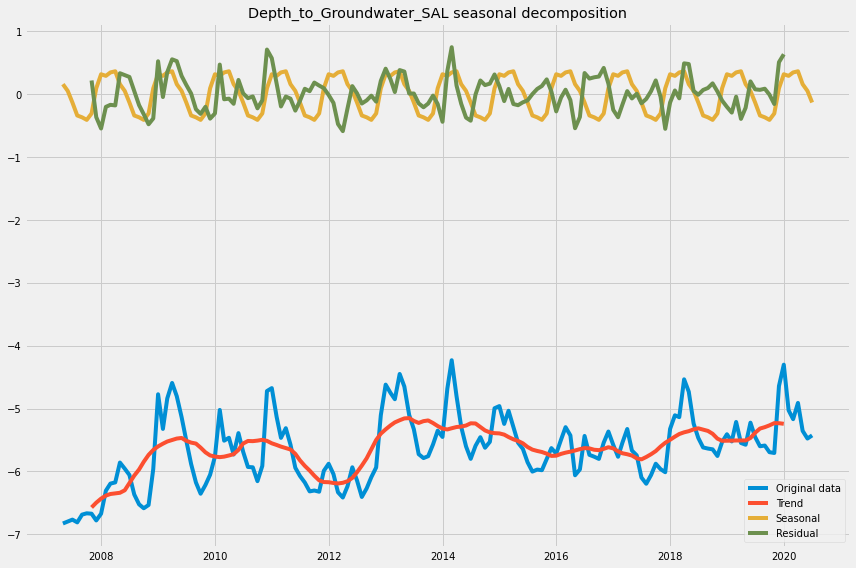

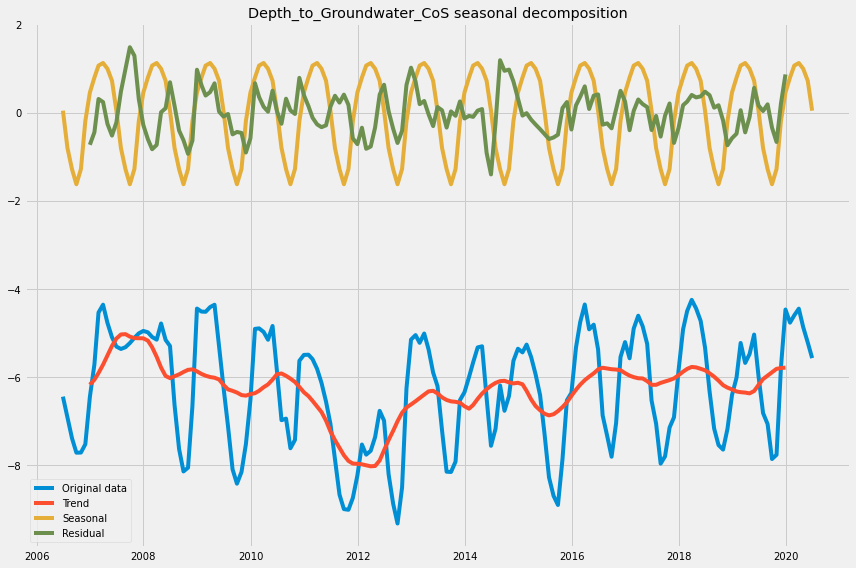

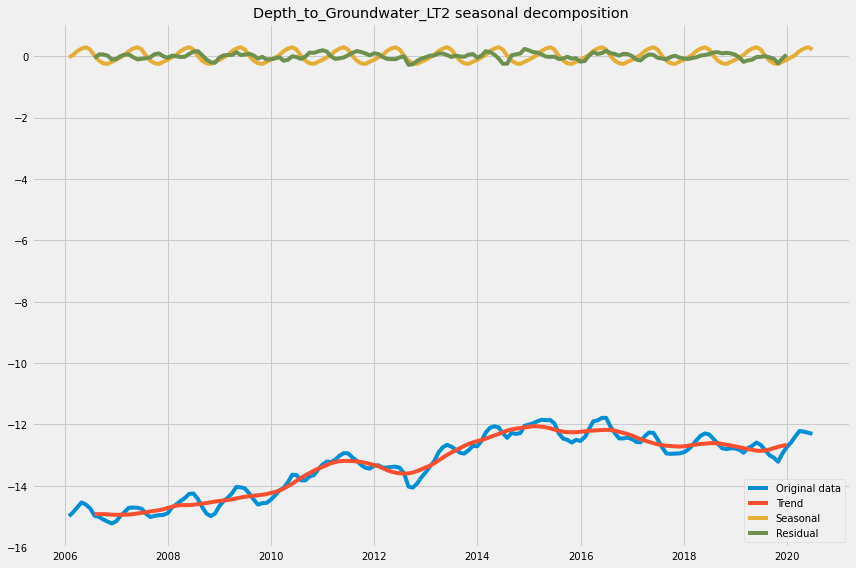

In [381]:
plot_seasonality(data, target_cols)

In [382]:
# Feature engineering
data = add_weekly_averages(data)
data = add_seasonality(data)

<ipython-input-368-56c12b2a9782>:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['Week'] = df.index.weekofyear


In [383]:
# Create monthly models and make a forecast
modelling(data, target_cols, 'Auser Aquifer', 'monthly', 1)


Creating monthly model for Auser Aquifer

Regression cross-val score for Depth_to_Groundwater_SAL:
	R2 = -1.9381955504849442
	MAE = 0.38792743202519914
	RMSE = 0.27757020092771273
Decision Tree cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.08967704840059794
	MAE = 0.19714685291333267
	RMSE = 0.06204310493252043
Extra Trees cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.26747400364612
	MAE = 0.22078295701065218
	RMSE = 0.07089093084553562
Random Forest cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.4209546363978783
	MAE = 0.19025266185077172
	RMSE = 0.056861628310072854
AdaBoost cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.35752970311658067
	MAE = 0.2105559038804303
	RMSE = 0.06364483414843548
Skl GBM cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.4128152548391361
	MAE = 0.1942159713784184
	RMSE = 0.05269108828883375
XGBoost cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.24303697148831496
	MAE = 0.21873182032569968
	RMSE = 0.0679361054271644

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

89:	learn: 0.0074537	total: 129ms	remaining: 14.3ms
90:	learn: 0.0071839	total: 130ms	remaining: 12.9ms
91:	learn: 0.0069052	total: 131ms	remaining: 11.4ms
92:	learn: 0.0066700	total: 132ms	remaining: 9.96ms
93:	learn: 0.0064548	total: 134ms	remaining: 8.53ms
94:	learn: 0.0062041	total: 135ms	remaining: 7.1ms
95:	learn: 0.0060304	total: 136ms	remaining: 5.67ms
96:	learn: 0.0057966	total: 138ms	remaining: 4.27ms
97:	learn: 0.0055727	total: 140ms	remaining: 2.85ms
98:	learn: 0.0053582	total: 141ms	remaining: 1.43ms
99:	learn: 0.0051527	total: 144ms	remaining: 0us
Learning rate set to 0.145641
0:	learn: 0.2980219	total: 1.29ms	remaining: 128ms
1:	learn: 0.2847792	total: 3.94ms	remaining: 193ms
2:	learn: 0.2737387	total: 5.53ms	remaining: 179ms
3:	learn: 0.2623725	total: 6.87ms	remaining: 165ms
4:	learn: 0.2503557	total: 8ms	remaining: 152ms
5:	learn: 0.2368077	total: 9.35ms	remaining: 146ms
6:	learn: 0.2261068	total: 10.8ms	remaining: 143ms
7:	learn: 0.2143275	total: 12.1ms	remaining: 140

C:\Users\shahi\anaconda3\envs\strive\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(



AdaBoost monthly prediction for Depth_to_Groundwater_CoS: -7.055677419354838

Input features: Rainfall_Gallicano, Rainfall_Pontetetto, Rainfall_Monte_Serra, Rainfall_Orentano, Rainfall_Borgo_a_Mozzano, Rainfall_Piaggione, Rainfall_Calavorno, Rainfall_Croce_Arcana, Rainfall_Tereglio_Coreglia_Antelminelli, Rainfall_Fabbriche_di_Vallico, Depth_to_Groundwater_SAL, Depth_to_Groundwater_PAG, Depth_to_Groundwater_CoS, Depth_to_Groundwater_DIEC, Temperature_Orentano, Temperature_Monte_Serra, Temperature_Ponte_a_Moriano, Temperature_Lucca_Orto_Botanico, Volume_POL, Volume_CC1, Volume_CC2, Volume_CSA, Hydrometry_Monte_S_Quirico, Hydrometry_Piaggione, Rainfall_Gallicano_weekly, Rainfall_Pontetetto_weekly, Rainfall_Monte_Serra_weekly, Rainfall_Orentano_weekly, Rainfall_Borgo_a_Mozzano_weekly, Rainfall_Piaggione_weekly, Rainfall_Calavorno_weekly, Rainfall_Croce_Arcana_weekly, Rainfall_Tereglio_Coreglia_Antelminelli_weekly, Rainfall_Fabbriche_di_Vallico_weekly, Temperature_Orentano_weekly, Temperat

C:\Users\shahi\anaconda3\envs\strive\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [384]:
# Create daily models and make a forecast
modelling(data, target_cols, 'Auser Aquifer', 'daily', 1)


Creating daily model for Auser Aquifer

Regression cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.9867424684245546
	MAE = 0.02155656022057616
	RMSE = 0.0012116940639755516
Decision Tree cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.9698590609733633
	MAE = 0.034138114816506776
	RMSE = 0.003085664856267869
Extra Trees cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.9831422967400352
	MAE = 0.022819024415004385
	RMSE = 0.001574458169974441
Random Forest cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.9806147092896084
	MAE = 0.02515338053905894
	RMSE = 0.0018107020240935026
AdaBoost cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.9728303511587614
	MAE = 0.03618898549953551
	RMSE = 0.002463979513715652
Skl GBM cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.9843986848238915
	MAE = 0.02489612017316749
	RMSE = 0.0014256722311064664
XGBoost cross-val score for Depth_to_Groundwater_SAL:
	R2 = 0.9806998261287591
	MAE = 0.028917778542390207
	RMSE = 0.0017747

C:\Users\shahi\anaconda3\envs\strive\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Regression cross-val score for Depth_to_Groundwater_CoS:
	R2 = 0.9980206295871167
	MAE = 0.044632030684704734
	RMSE = 0.0032767729190365693
Decision Tree cross-val score for Depth_to_Groundwater_CoS:
	R2 = 0.995006710264955
	MAE = 0.06950352582428053
	RMSE = 0.008739979512102149
Extra Trees cross-val score for Depth_to_Groundwater_CoS:
	R2 = 0.9980452722392316
	MAE = 0.043965820468839484
	RMSE = 0.0032256730674195076
Random Forest cross-val score for Depth_to_Groundwater_CoS:
	R2 = 0.9972593957250894
	MAE = 0.05151713455307805
	RMSE = 0.004563138187011626
AdaBoost cross-val score for Depth_to_Groundwater_CoS:
	R2 = 0.9955720342605449
	MAE = 0.067408494576266
	RMSE = 0.0075994947630203405
Skl GBM cross-val score for Depth_to_Groundwater_CoS:
	R2 = 0.9974786151732355
	MAE = 0.05074484887706456
	RMSE = 0.004179253944235398
XGBoost cross-val score for Depth_to_Groundwater_CoS:
	R2 = 0.9958226598160298
	MAE = 0.06109838704324938
	RMSE = 0.006892724410726858
LightGBM cross-val score for Dept

C:\Users\shahi\anaconda3\envs\strive\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(



Extra Trees daily prediction for Depth_to_Groundwater_CoS: -6.080000000000002

Input features: Depth_to_Groundwater_SAL, Depth_to_Groundwater_PAG, Depth_to_Groundwater_CoS, Depth_to_Groundwater_DIEC, Temperature_Orentano, Temperature_Monte_Serra, Temperature_Ponte_a_Moriano, Temperature_Lucca_Orto_Botanico, Volume_POL, Volume_CC2, Volume_CSA, Hydrometry_Monte_S_Quirico, Hydrometry_Piaggione, Rainfall_Monte_Serra_weekly, Rainfall_Orentano_weekly, Rainfall_Borgo_a_Mozzano_weekly, Rainfall_Calavorno_weekly, Rainfall_Fabbriche_di_Vallico_weekly, Temperature_Orentano_weekly, Temperature_Monte_Serra_weekly, Temperature_Ponte_a_Moriano_weekly, Temperature_Lucca_Orto_Botanico_weekly, Month, Week, Day, Rainy_Season, Rainfall_Gallicano_weekly_weekly, Rainfall_Pontetetto_weekly_weekly, Rainfall_Monte_Serra_weekly_weekly, Rainfall_Orentano_weekly_weekly, Rainfall_Borgo_a_Mozzano_weekly_weekly, Rainfall_Piaggione_weekly_weekly, Rainfall_Calavorno_weekly_weekly, Rainfall_Tereglio_Coreglia_Antelmine

C:\Users\shahi\anaconda3\envs\strive\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Lake Bilancino

In [385]:
data = get_data(Bilancino_path)

In [386]:
target_cols = targets['Bilancino']

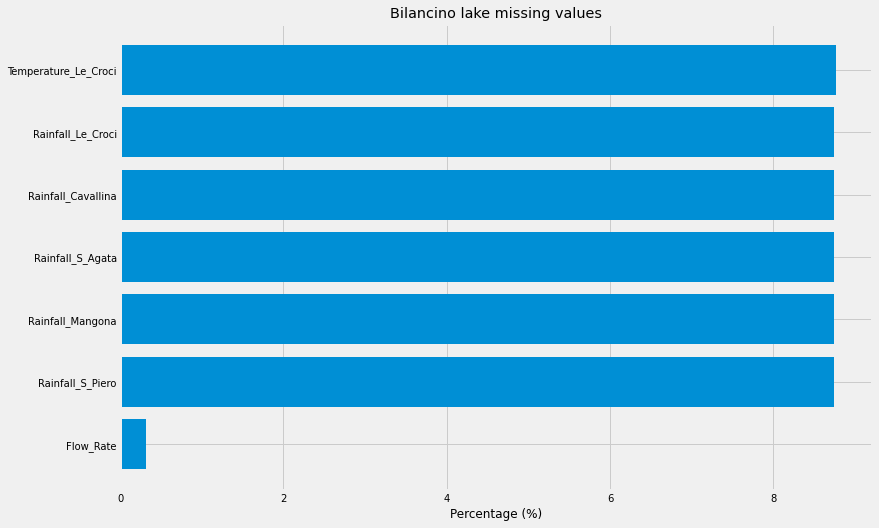

In [387]:
plot_nans(data, 'Bilancino lake')

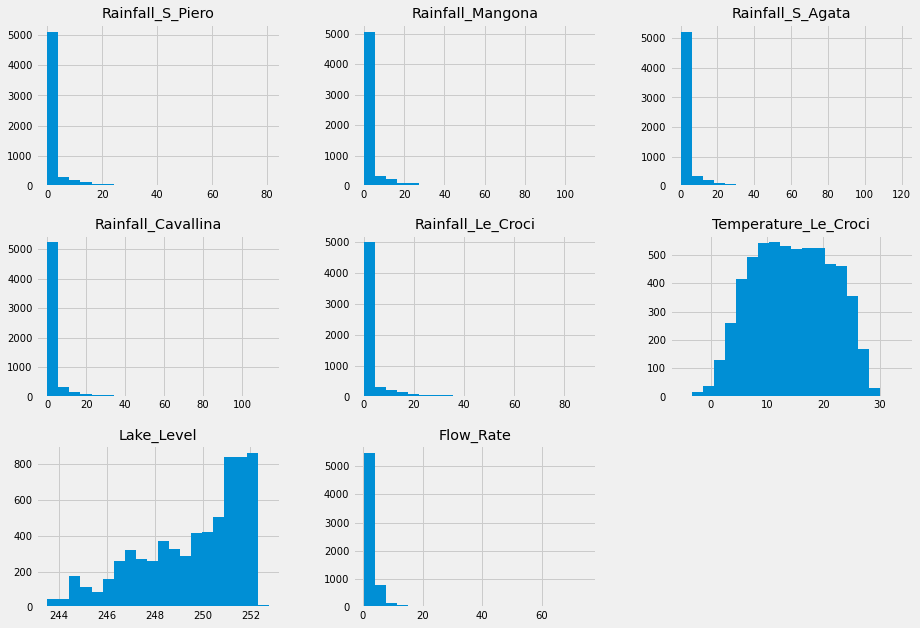

In [388]:
plot_distribution(data)

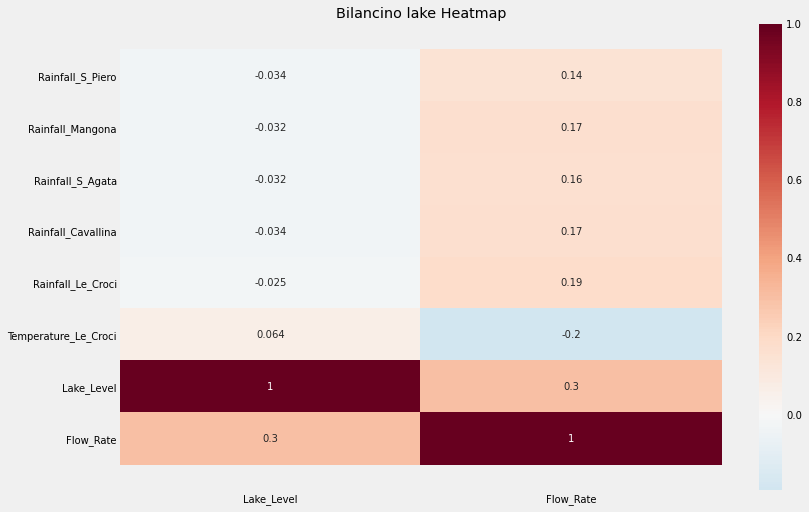

In [389]:
plot_correlation(data, 'Bilancino lake', target_cols)

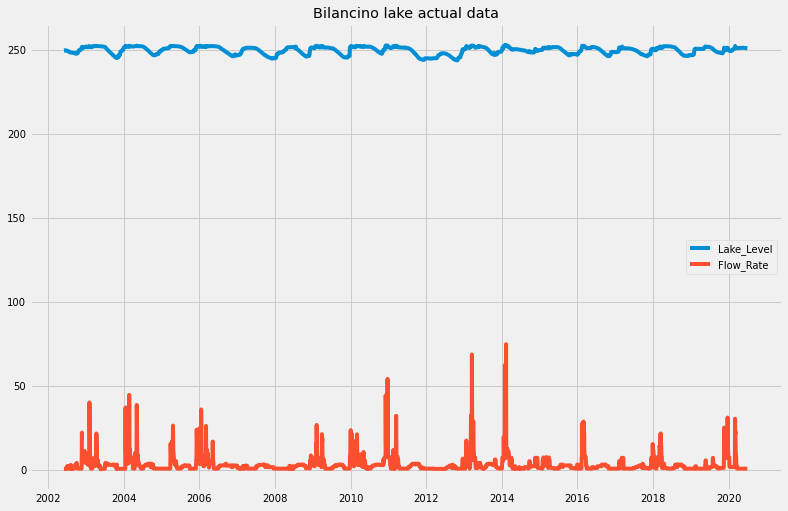

In [390]:
plot_timeseries(data, 'Bilancino lake', target_cols)

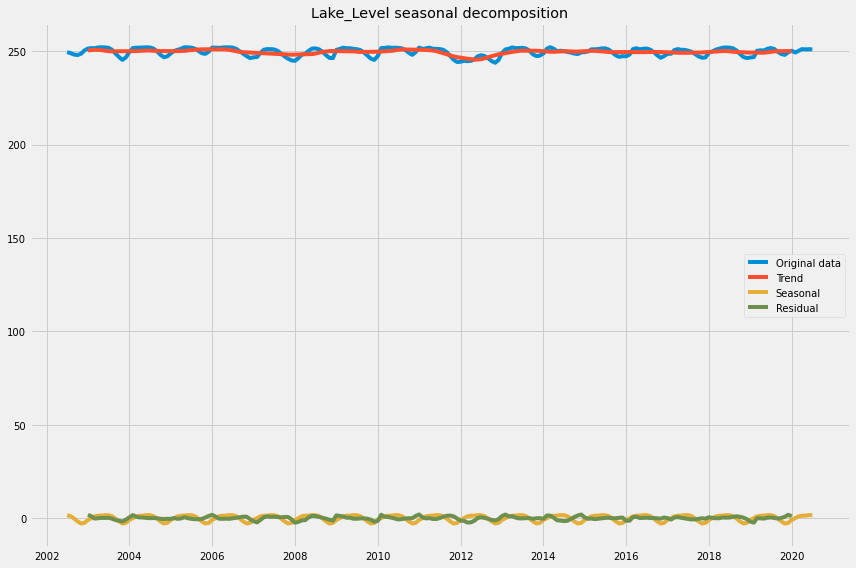

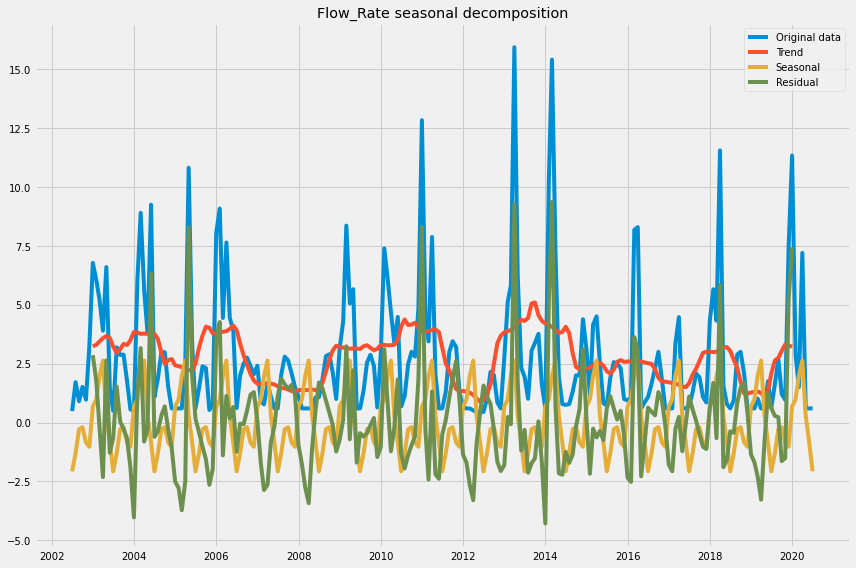

In [391]:
plot_seasonality(data, target_cols)

In [392]:
# Feature engineering
data = add_weekly_averages(data)
data = add_seasonality(data)

<ipython-input-368-56c12b2a9782>:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['Week'] = df.index.weekofyear


In [393]:
# Create monthly models and make a forecast
modelling(data, target_cols, 'Bilancino lake', 'monthly', 1)


Creating monthly model for Bilancino lake

Regression cross-val score for Lake_Level:
	R2 = 0.9194458193889852
	MAE = 0.4579797296270381
	RMSE = 0.36178084019463563
Decision Tree cross-val score for Lake_Level:
	R2 = 0.7173114897061508
	MAE = 0.7870904033819017
	RMSE = 1.3176276435914867
Extra Trees cross-val score for Lake_Level:
	R2 = 0.8892743096432637
	MAE = 0.47030427545401726
	RMSE = 0.4981834859996954
Random Forest cross-val score for Lake_Level:
	R2 = 0.8773817622996409
	MAE = 0.541307028056945
	RMSE = 0.5902521520662147
AdaBoost cross-val score for Lake_Level:
	R2 = 0.8393812531929031
	MAE = 0.6584089787698092
	RMSE = 0.7227460022335457
Skl GBM cross-val score for Lake_Level:
	R2 = 0.8919081632472677
	MAE = 0.5040704476262783
	RMSE = 0.4941806179342289
XGBoost cross-val score for Lake_Level:
	R2 = 0.8804475797232865
	MAE = 0.5341980402770478
	RMSE = 0.5510507340845336
LightGBM cross-val score for Lake_Level:
	R2 = 0.8316344099206231
	MAE = 0.5998492716586257
	RMSE = 0.7682651

C:\Users\shahi\anaconda3\envs\strive\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Decision Tree cross-val score for Flow_Rate:
	R2 = -0.5916477309380501
	MAE = 1.8157108038791019
	RMSE = 11.29042103223872
Extra Trees cross-val score for Flow_Rate:
	R2 = 0.463180736372024
	MAE = 1.3228254314914272
	RMSE = 4.166771466993948
Random Forest cross-val score for Flow_Rate:
	R2 = 0.33222867554429086
	MAE = 1.4186270559523286
	RMSE = 5.03409181220784
AdaBoost cross-val score for Flow_Rate:
	R2 = 0.3306941606986011
	MAE = 1.6676149916756675
	RMSE = 5.397078819413601
Skl GBM cross-val score for Flow_Rate:
	R2 = 0.3474088038975747
	MAE = 1.476193703147291
	RMSE = 5.346467052965555
XGBoost cross-val score for Flow_Rate:
	R2 = 0.1985786576147763
	MAE = 1.6220474630836008
	RMSE = 6.421086085561126
LightGBM cross-val score for Flow_Rate:
	R2 = 0.2861889873953331
	MAE = 1.5756870338125681
	RMSE = 5.656974733765615
Learning rate set to 0.193067
0:	learn: 2.5131095	total: 2.41ms	remaining: 238ms
1:	learn: 2.4034578	total: 4.36ms	remaining: 214ms
2:	learn: 2.2782452	total: 6.64ms	remai

In [394]:
# Create daily models and make a forecast
modelling(data, target_cols, 'Bilancino lake', 'daily', 1)


Creating daily model for Bilancino lake

Regression cross-val score for Lake_Level:
	R2 = 0.9977156205244065
	MAE = 0.04510945883094566
	RMSE = 0.010786183495208263
Decision Tree cross-val score for Lake_Level:
	R2 = 0.9964564971546851
	MAE = 0.050212687450734504
	RMSE = 0.016401203010795215
Extra Trees cross-val score for Lake_Level:
	R2 = 0.9977982457022732
	MAE = 0.040106777427073644
	RMSE = 0.010423204185854342
Random Forest cross-val score for Lake_Level:
	R2 = 0.99771098555743
	MAE = 0.041516108286890396
	RMSE = 0.010804849867105079
AdaBoost cross-val score for Lake_Level:
	R2 = 0.9868540949360249
	MAE = 0.18548775004317108
	RMSE = 0.06349957052966372
Skl GBM cross-val score for Lake_Level:
	R2 = 0.9977945938765624
	MAE = 0.04609425267443266
	RMSE = 0.010423805111000101
XGBoost cross-val score for Lake_Level:
	R2 = 0.997628788968961
	MAE = 0.04497875638529075
	RMSE = 0.011196815014030569
LightGBM cross-val score for Lake_Level:
	R2 = 0.997806664496656
	MAE = 0.045736533570702044

C:\Users\shahi\anaconda3\envs\strive\lib\site-packages\lightgbm\basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


### Waterspring AMIATA

In [395]:
data = get_data(Amiata_path)

In [396]:
target_cols = targets['Amiata']

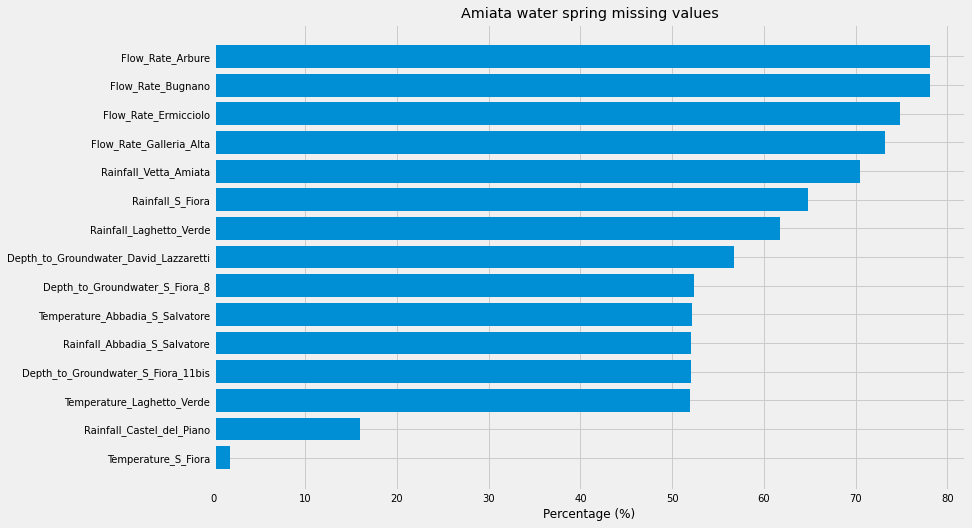

In [397]:
plot_nans(data, 'Amiata water spring')

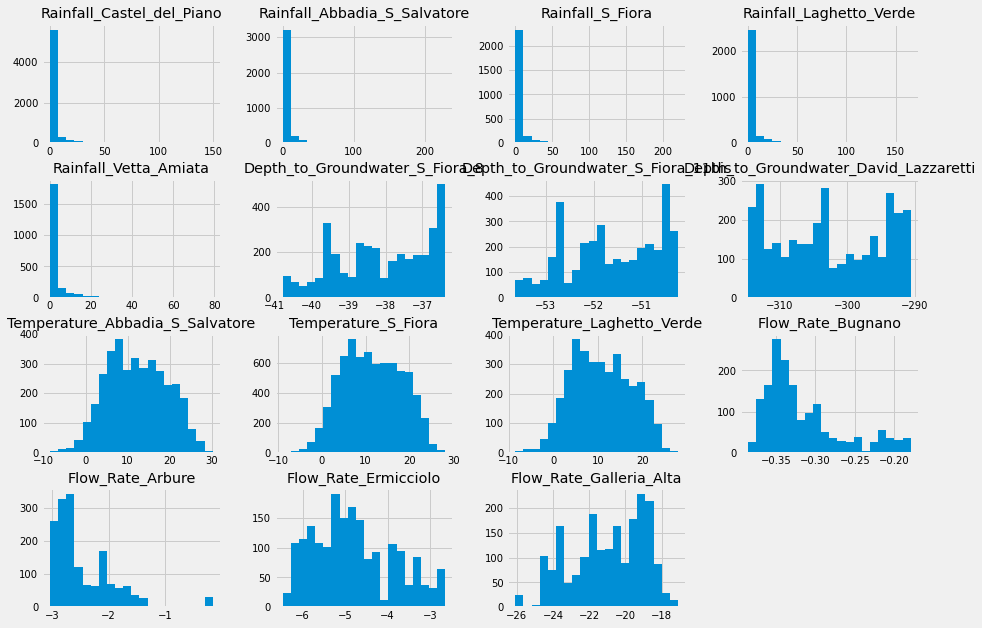

In [398]:
plot_distribution(data)

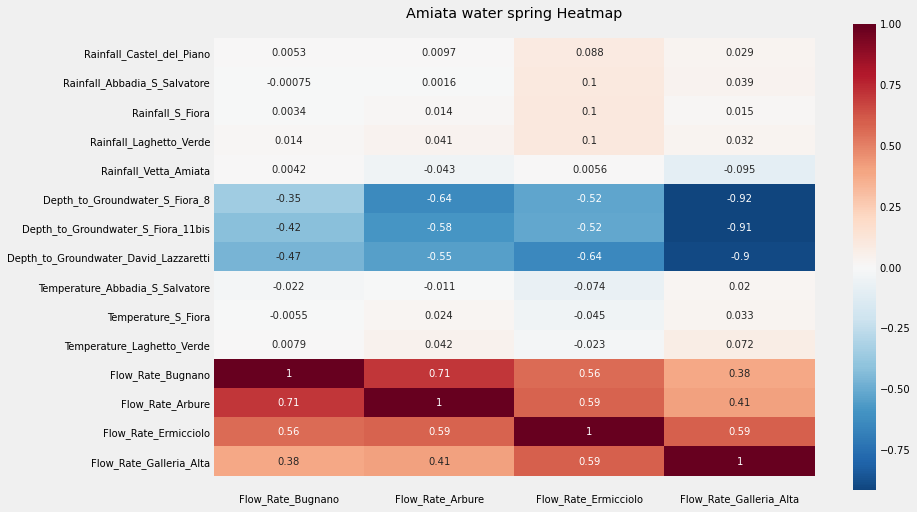

In [399]:
plot_correlation(data, 'Amiata water spring', target_cols)

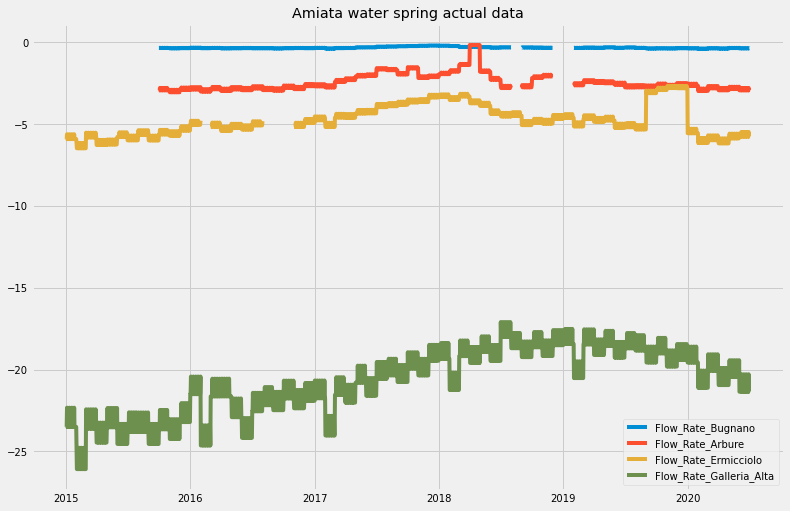

In [400]:
plot_timeseries(data, 'Amiata water spring', target_cols)

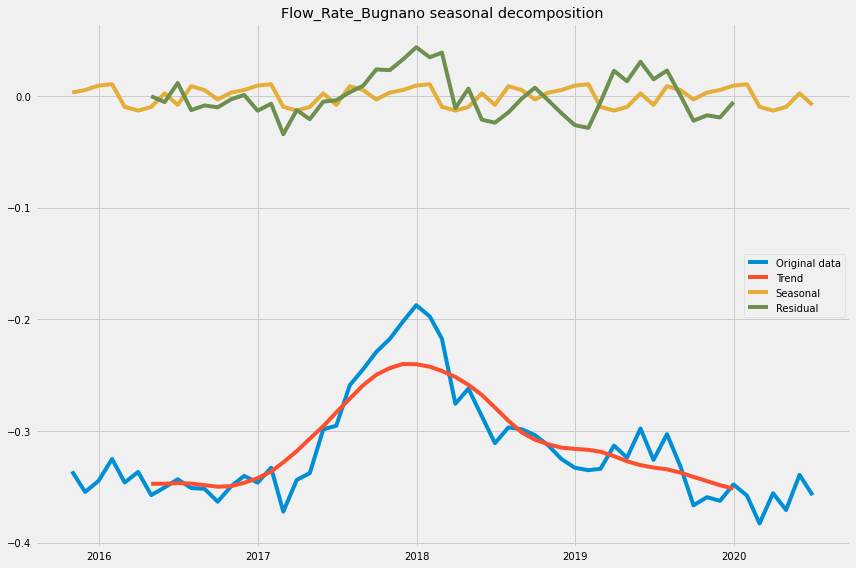

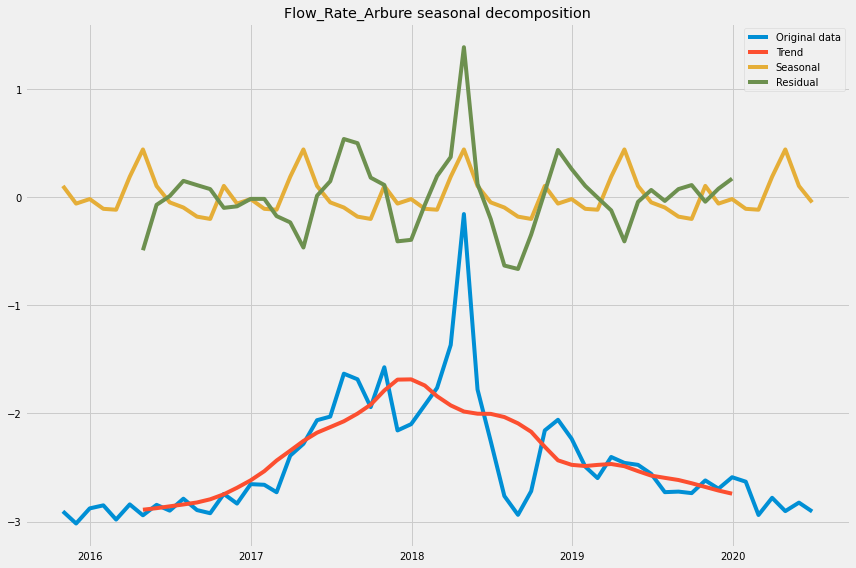

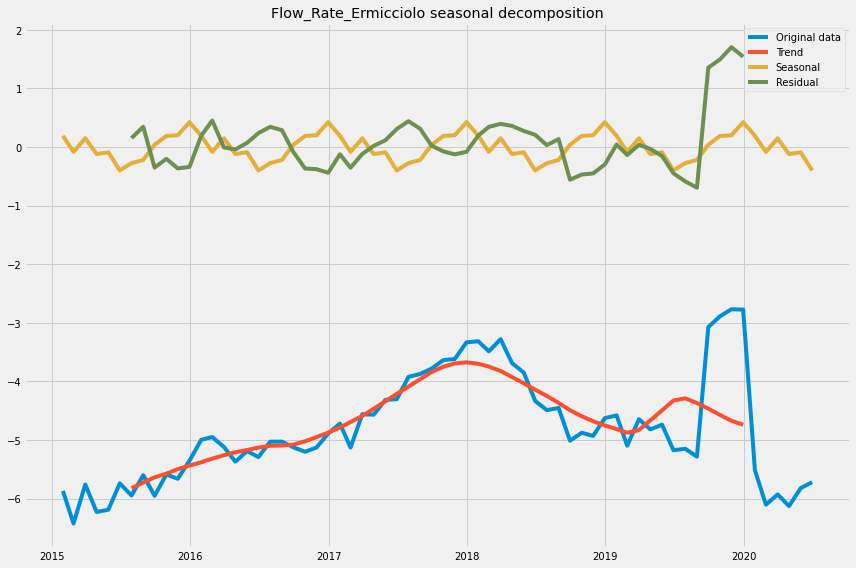

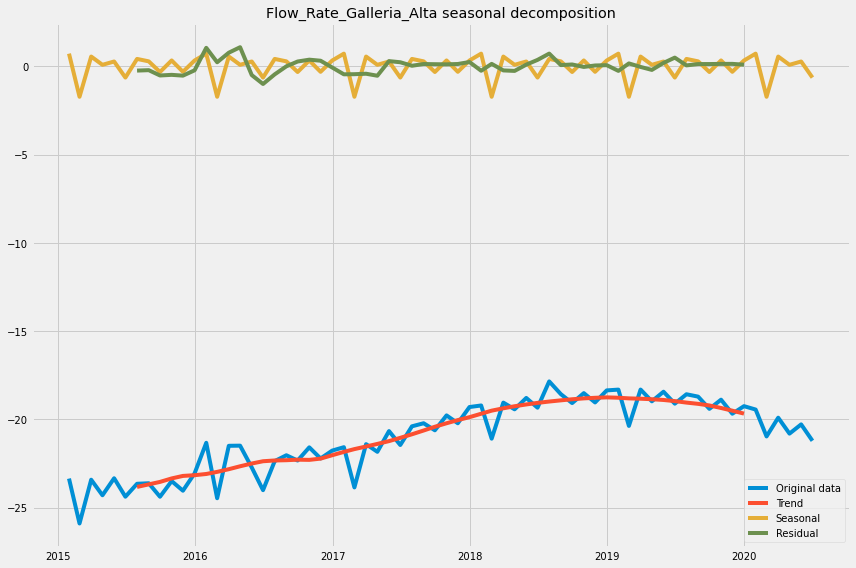

In [401]:
plot_seasonality(data, target_cols)

In [402]:
# Feature engineering
data = add_weekly_averages(data)
data = add_seasonality(data)

<ipython-input-368-56c12b2a9782>:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['Week'] = df.index.weekofyear


In [403]:
# Create monthly models and make a forecast
modelling(data, target_cols, 'Amiata water spring', 'monthly', 1)


Creating monthly model for Amiata water spring

Regression cross-val score for Flow_Rate_Bugnano:
	R2 = 0.010146724731116996
	MAE = 0.018687274000245578
	RMSE = 0.00046542447966320204
Decision Tree cross-val score for Flow_Rate_Bugnano:
	R2 = -0.7823653887074671
	MAE = 0.02113106775710887
	RMSE = 0.0008340724750973142
Extra Trees cross-val score for Flow_Rate_Bugnano:
	R2 = 0.13035561371463364
	MAE = 0.015757950845942042
	RMSE = 0.00037091806419183986
Random Forest cross-val score for Flow_Rate_Bugnano:
	R2 = 0.06709272189405528
	MAE = 0.015858422925887416
	RMSE = 0.00042283290924236943
AdaBoost cross-val score for Flow_Rate_Bugnano:
	R2 = 0.06102320383542659
	MAE = 0.015609746204113173
	RMSE = 0.00038007831154418005
Skl GBM cross-val score for Flow_Rate_Bugnano:
	R2 = -0.3215698605471174
	MAE = 0.018236762715575575
	RMSE = 0.0005598765340071901
XGBoost cross-val score for Flow_Rate_Bugnano:
	R2 = -0.15806122923681368
	MAE = 0.01835870068953629
	RMSE = 0.0005440009697406365
LightGBM c

C:\Users\shahi\anaconda3\envs\strive\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


In [404]:
# Create daily models and make a forecast
modelling(data, target_cols, 'Amiata water spring', 'daily', 1)


Creating daily model for Amiata water spring

Regression cross-val score for Flow_Rate_Bugnano:
	R2 = 0.8421751706946733
	MAE = 0.006218717481430301
	RMSE = 8.341969969844382e-05
Decision Tree cross-val score for Flow_Rate_Bugnano:
	R2 = 0.8123946177697966
	MAE = 0.005099833508773989
	RMSE = 9.920665101571953e-05
Extra Trees cross-val score for Flow_Rate_Bugnano:
	R2 = 0.8466980777161078
	MAE = 0.00523061544868512
	RMSE = 8.080754949942395e-05
Random Forest cross-val score for Flow_Rate_Bugnano:
	R2 = 0.8530973104928185
	MAE = 0.005532356737756661
	RMSE = 7.746876900478594e-05
AdaBoost cross-val score for Flow_Rate_Bugnano:
	R2 = 0.8464592172068025
	MAE = 0.006927389955307745
	RMSE = 8.331103562350007e-05
Skl GBM cross-val score for Flow_Rate_Bugnano:
	R2 = 0.8830231329224537
	MAE = 0.0052708997876536115
	RMSE = 6.19674304680329e-05
XGBoost cross-val score for Flow_Rate_Bugnano:
	R2 = 0.8565392551931824
	MAE = 0.005485927293398414
	RMSE = 7.600023732454736e-05
LightGBM cross-val score

C:\Users\shahi\anaconda3\envs\strive\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Decision Tree cross-val score for Flow_Rate_Arbure:
	R2 = 0.8799690419043363
	MAE = 0.04296409959537812
	RMSE = 0.006182637477072244
Extra Trees cross-val score for Flow_Rate_Arbure:
	R2 = 0.9040636848217275
	MAE = 0.040949531031380076
	RMSE = 0.0051918803988819555
Random Forest cross-val score for Flow_Rate_Arbure:
	R2 = 0.9110530594396787
	MAE = 0.04354872532007209
	RMSE = 0.004769052725066125
AdaBoost cross-val score for Flow_Rate_Arbure:
	R2 = 0.8961342469592125
	MAE = 0.057539184836359815
	RMSE = 0.005511503052317302
Skl GBM cross-val score for Flow_Rate_Arbure:
	R2 = 0.92440808970052
	MAE = 0.04215345341020096
	RMSE = 0.004071027420570163
XGBoost cross-val score for Flow_Rate_Arbure:
	R2 = 0.9047781217034608
	MAE = 0.04299133181623347
	RMSE = 0.005109782800572564
LightGBM cross-val score for Flow_Rate_Arbure:
	R2 = 0.9230014859240759
	MAE = 0.04374279772287567
	RMSE = 0.004137209422080489
Learning rate set to 0.244497
0:	learn: 0.1888598	total: 1.94ms	remaining: 192ms
1:	learn: 0

C:\Users\shahi\anaconda3\envs\strive\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
